In [34]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

In [27]:
df = pd.read_csv('US100.csv', sep=',', usecols=['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'])
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

df.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,
2020-03-03,8838.50,9000.75,8540.64,8559.12,640841
2020-03-04,8547.80,8949.85,8511.88,8889.48,534261
2020-03-05,8885.85,8899.10,8612.16,8674.98,363011
2020-03-06,8672.30,8726.60,8314.22,8505.60,658061
2020-03-09,8173.85,8243.98,7823.60,7920.48,587381


In [28]:
df['up/down/even day'] = 'even'
df.loc[df['CLOSE'] > df['OPEN'], 'up/down/even day'] = 'up'
df.loc[df['CLOSE'] < df['OPEN'], 'up/down/even day'] = 'down'

df.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,up/down/even day
DATE,,,,,,
2020-03-03,8838.50,9000.75,8540.64,8559.12,640841,down
2020-03-04,8547.80,8949.85,8511.88,8889.48,534261,up
2020-03-05,8885.85,8899.10,8612.16,8674.98,363011,down
2020-03-06,8672.30,8726.60,8314.22,8505.60,658061,down
2020-03-09,8173.85,8243.98,7823.60,7920.48,587381,down


In [29]:
df['prev_day'] = df['up/down/even day'].shift(1)
df['amplitude'] = df['HIGH'] - df['LOW']
df['body'] = df['CLOSE'] - df['OPEN']

def get_side(prev):
    if prev == 'down':
        return 'long'
    elif prev == 'up':
        return 'short'
    return None

df['side'] = df['prev_day'].apply(get_side)

In [30]:
def calc_pnl(row):
    if row['side'] == 'long':
        return row['CLOSE'] - row['OPEN']
    elif row['side'] == 'short':
        return row['OPEN'] - row['CLOSE']
    return 0.0

df['pnl_pts'] = df.apply(calc_pnl, axis=1)

df['year'] = df.index.year

trades = df[df['side'].notna()].copy()

In [31]:
rows = []
for year, grp_all in df.groupby('year'):
    grp_trades = trades[trades['year'] == year]
    longs  = grp_trades[grp_trades['side'] == 'long']
    shorts = grp_trades[grp_trades['side'] == 'short']

    up_days   = grp_all[grp_all['up/down/even day'] == 'up']
    down_days = grp_all[grp_all['up/down/even day'] == 'down']

    first_open = grp_all['OPEN'].iloc[0]
    last_close = grp_all['CLOSE'].iloc[-1]
    retorno_anual = (last_close - first_open) / first_open * 100
    
    # media de um dia de alta/baixa
    up_avg   = up_days['body'].mean()          
    down_avg = down_days['body'].abs().mean()  

    # > 1 = dias de baixa maiores que os de alta
    assimetria = down_avg / up_avg if up_avg > 0 else 0

    rows.append({
        'Ano'              : year,
        'Retorno índice %' : round(retorno_anual, 1),
        'Regime'           : 'BEAR' if retorno_anual < 0 else 'BULL',
        'P&L total (pts)'  : round(grp_trades['pnl_pts'].sum(), 1),
        'Long P&L'         : round(longs['pnl_pts'].sum(), 1),
        'Short P&L'        : round(shorts['pnl_pts'].sum(), 1),
        'Mag. dias alta'   : round(up_avg, 1),
        'Mag. dias baixa'  : round(down_avg, 1),
        'Assimetria B/A'   : round(assimetria, 3),
        'Amplitude H-L'    : round(grp_all['amplitude'].mean(), 1),
        '% dias alta'      : round((grp_all['up/down/even day'] == 'up').mean() * 100, 1),
        '% dias baixa'     : round((grp_all['up/down/even day'] == 'down').mean() * 100, 1),
    })

summary = pd.DataFrame(rows).set_index('Ano')

In [32]:
print("\n" + "═"*70)
print("  SISTEMA VS REGIME DE MERCADO")
print("═"*70)
print(f"{'Ano':>5} {'Regime':>8} {'Índice%':>9} {'P&L':>9} {'Mag↑':>7} {'Mag↓':>7} "
      f"{'Assim↓/↑':>9} {'%Alta':>6} {'%Baixa':>7}")
print("─"*70)
for year, r in summary.iterrows():
    print(f"  {year}  {r['Regime']:>8}  {r['Retorno índice %']:>+7.1f}%  "
          f"{r['P&L total (pts)']:>+9.1f}  {r['Mag. dias alta']:>6.1f}  "
          f"{r['Mag. dias baixa']:>6.1f}  {r['Assimetria B/A']:>8.3f}  "
          f"{r['% dias alta']:>5.1f}%  {r['% dias baixa']:>6.1f}%")
print("═"*70)

# Correlação do P&L com retorno do índice
corr = summary['P&L total (pts)'].corr(summary['Retorno índice %'])
corr_assim = summary['P&L total (pts)'].corr(summary['Assimetria B/A'])
print(f"\n  Correlação P&L ↔ Retorno índice   : {corr:+.3f}")
print(f"  Correlação P&L ↔ Assimetria (↓/↑) : {corr_assim:+.3f}")
print(f"\n  → Assimetria > 1.0 = dias de baixa têm candles maiores que dias de alta")
print(f"  → Assimetria < 1.0 = dias de alta têm candles maiores que dias de baixa")
print()


══════════════════════════════════════════════════════════════════════
  SISTEMA VS REGIME DE MERCADO
══════════════════════════════════════════════════════════════════════
  Ano   Regime   Índice%       P&L    Mag↑    Mag↓  Assim↓/↑  %Alta  %Baixa
──────────────────────────────────────────────────────────────────────
  2020      BULL    +45.9%    +3029.5   141.1   161.0     1.141   60.2%    39.8%
  2021      BULL    +26.6%    +2176.9   122.2   129.3     1.058   55.2%    44.8%
  2022      BEAR    -33.2%    +4529.6   195.4   200.6     1.027   46.5%    53.5%
  2023      BULL    +52.8%    +1727.0   122.8   110.0     0.896   57.0%    43.0%
  2024      BULL    +24.9%     -690.0   148.3   171.7     1.158   57.1%    42.9%
  2025      BEAR     -1.2%     -390.9   181.4   186.1     1.026   52.4%    47.6%
══════════════════════════════════════════════════════════════════════

  Correlação P&L ↔ Retorno índice   : -0.248
  Correlação P&L ↔ Assimetria (↓/↑) : -0.161

  → Assimetria > 1.0 = dias de

Gráfico salvo em: regime_vs_pnl.png


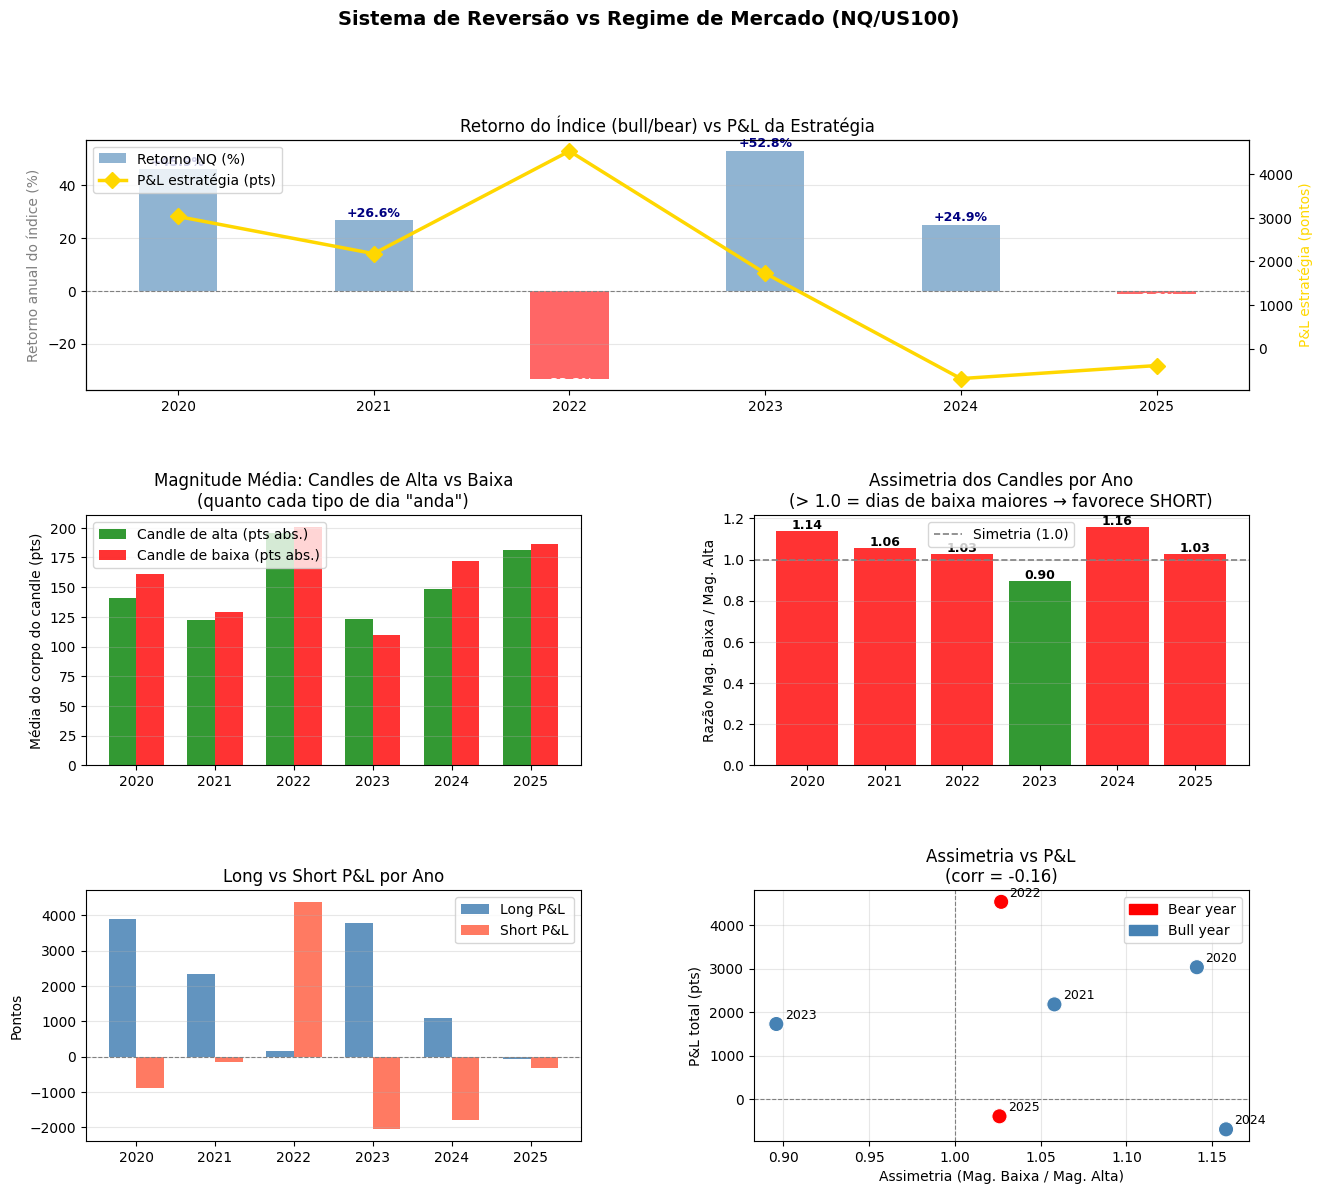

In [35]:
anos  = summary.index.astype(str).tolist()
cores = ['red' if r < 0 else 'steelblue' for r in summary['Retorno índice %']]

fig = plt.figure(figsize=(15, 13))
fig.suptitle('Sistema de Reversão vs Regime de Mercado (NQ/US100)',
             fontsize=14, fontweight='bold')
gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.50, wspace=0.35)

# Retorno do índice vs P&L da estratégia
ax1 = fig.add_subplot(gs[0, :])
ax1b = ax1.twinx()
bars = ax1.bar(anos, summary['Retorno índice %'], color=cores, alpha=0.6, label='Retorno NQ (%)', width=0.4)
ax1b.plot(anos, summary['P&L total (pts)'], color='gold', marker='D',
          linewidth=2.5, markersize=8, label='P&L estratégia (pts)', zorder=5)
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax1.set_ylabel('Retorno anual do índice (%)', color='gray')
ax1b.set_ylabel('P&L estratégia (pontos)', color='gold')
ax1.set_title('Retorno do Índice (bull/bear) vs P&L da Estratégia')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, summary['Retorno índice %']):
    ax1.text(bar.get_x() + bar.get_width()/2, val + (1.5 if val >= 0 else -3),
             f'{val:+.1f}%', ha='center', fontsize=9, fontweight='bold', color='white' if val < 0 else 'navy')

# Magnitude: dias de alta vs dias de baixa
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(len(anos)); w = 0.35
ax2.bar(x - w/2, summary['Mag. dias alta'],  width=w, color='green', alpha=0.8, label='Candle de alta (pts abs.)')
ax2.bar(x + w/2, summary['Mag. dias baixa'], width=w, color='red',   alpha=0.8, label='Candle de baixa (pts abs.)')
ax2.set_xticks(x); ax2.set_xticklabels(anos)
ax2.set_ylabel('Média do corpo do candle (pts)')
ax2.set_title('Magnitude Média: Candles de Alta vs Baixa\n(quanto cada tipo de dia "anda")')
ax2.legend(); ax2.grid(True, alpha=0.3, axis='y')

# Assimetria baixa/alta
ax3 = fig.add_subplot(gs[1, 1])
cores_assim = ['red' if v > 1 else 'green' for v in summary['Assimetria B/A']]
bars3 = ax3.bar(anos, summary['Assimetria B/A'], color=cores_assim, alpha=0.8)
ax3.axhline(1.0, color='gray', linestyle='--', linewidth=1.2, label='Simetria (1.0)')
ax3.set_ylabel('Razão Mag. Baixa / Mag. Alta')
ax3.set_title('Assimetria dos Candles por Ano\n(> 1.0 = dias de baixa maiores → favorece SHORT)')
ax3.legend(); ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, summary['Assimetria B/A']):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.01,
             f'{val:.2f}', ha='center', fontsize=9, fontweight='bold')

# Long vs Short decomposição
ax4 = fig.add_subplot(gs[2, 0])
x = np.arange(len(anos))
ax4.bar(x - w/2, summary['Long P&L'],  width=w, color='steelblue', alpha=0.85, label='Long P&L')
ax4.bar(x + w/2, summary['Short P&L'], width=w, color='tomato',    alpha=0.85, label='Short P&L')
ax4.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax4.set_xticks(x); ax4.set_xticklabels(anos)
ax4.set_ylabel('Pontos'); ax4.set_title('Long vs Short P&L por Ano')
ax4.legend(); ax4.grid(True, alpha=0.3, axis='y')

# Scatter: Assimetria vs P&L
ax5 = fig.add_subplot(gs[2, 1])
sc = ax5.scatter(summary['Assimetria B/A'], summary['P&L total (pts)'],
                 c=['red' if r < 0 else 'steelblue' for r in summary['Retorno índice %']],
                 s=120, zorder=5, edgecolors='white', linewidths=0.8)
for year, row in summary.iterrows():
    ax5.annotate(str(year), (row['Assimetria B/A'], row['P&L total (pts)']),
                 textcoords='offset points', xytext=(6, 4), fontsize=9)
ax5.axvline(1.0, color='gray', linestyle='--', linewidth=0.8)
ax5.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax5.set_xlabel('Assimetria (Mag. Baixa / Mag. Alta)')
ax5.set_ylabel('P&L total (pts)')
ax5.set_title(f'Assimetria vs P&L\n(corr = {corr_assim:+.2f})')
ax5.grid(True, alpha=0.3)

from matplotlib.patches import Patch

ax5.legend(handles=[Patch(color='red', label='Bear year'),
                    Patch(color='steelblue', label='Bull year')])

plt.savefig('regime_vs_pnl.png', dpi=150, bbox_inches='tight')
print("Gráfico salvo em: regime_vs_pnl.png")